# GalSim Demo #13: Simulating a WFIRST Image

> Copyright (c) 2012-2016 by the GalSim developers team on GitHub
> https://github.com/GalSim-developers
> 
> This file is part of GalSim: The modular galaxy image simulation toolkit.
> https://github.com/GalSim-developers/GalSim
> 
> GalSim is free software: redistribution and use in source and binary forms,
> with or without modification, are permitted provided that the following
> conditions are met:
> 
> 1. Redistributions of source code must retain the above copyright notice, this
>    list of conditions, and the disclaimer given in the accompanying LICENSE
>    file.
> 2. Redistributions in binary form must reproduce the above copyright notice,
>    this list of conditions, and the disclaimer given in the documentation
>    and/or other materials provided with the distribution.

This script introduces non-idealities arising from NIR detectors, in particular those that will be
observed and accounted for in the WFIRST survey. Three such non-ideal effects are demonstrated, in
the order in which they are introduced in the detectors:

  1. Reciprocity failure: Flux-dependent sensitivity of the detector.
  2. Non-linearity: Charge-dependent gain in converting from units of electrons to ADU.  Non-linearity
     in some form is also relevant for CCDs in addition to NIR detectors.
  3. Interpixel capacitance: Influence of charge in a pixel on the voltage reading of neighboring
     ones.

The purpose of the demo is two-fold: (1) to show the effects of detector non-idealities on images
from NIR detectors, and (2) to illustrate the full image generation process, including all sources
of noise at appropriate stages.

Note that the output images in all the passbands take up a bit under 400M of space, but when running
the code in 'diff mode' (which is not the default, but which makes difference images showing the
impact of each detector effect separately) they take up a bit over 2G.

New features introduced in this demo:

- image.quantize()
- Routines to include WFIRST-specific detector effects:
  - galsim.wfirst.addReciprocityFailure(image)
  - galsim.wfirst.applyNonlinearity(image)
  - galsim.wfirst.applyIPC(image)
- Routines to get basic information about WFIRST bandpasses, PSFs, and WCS:
  - galsim.wfirst.getBandpasses()
  - galsim.wfirst.getPSF()
  - galsim.wfirst.getWCS()
  - galsim.wfirst.allowedPos()
  - galsim.wfirst.getSkyLevel()

In [4]:
import numpy
import sys, os
import math
import logging
import time
import galsim as galsim
import galsim.wfirst as wfirst

# This is a setting that decides whether or not to output differences images showing what each
# detector effect does.  Since they take up quite a bit of space, we set this to False by default,
# but users who want to see the difference images can change it to True.
diff_mode = False

examples_path = os.path.abspath(os.path.join("..", "galsim-examples"))
datapath = os.path.abspath(os.path.join(examples_path, "data"))
outpath = os.path.abspath(os.path.join(".", "galsim_demo_output"))
print('Using', datapath, 'as the path to GalSim example data')

def main():
    # Where to find and output data.

    # Make output directory if not already present.
    if not os.path.isdir(outpath):
        os.mkdir(outpath)

    # In non-script code, use getLogger(__name__) at module scope instead.
    logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
    logger = logging.getLogger("demo13")

    # Initialize (pseudo-)random number generator.
    random_seed = 123456
    rng = galsim.BaseDeviate(random_seed)

    # Generate a Poisson noise model.
    poisson_noise = galsim.PoissonNoise(rng)
    logger.info('Poisson noise model created.')

    # Read in the WFIRST filters, setting an AB zeropoint appropriate for this telescope given its
    # diameter and (since we didn't use any keyword arguments to modify this) using the typical
    # exposure time for WFIRST images.  By default, this routine truncates the parts of the
    # bandpasses that are near 0 at the edges, and thins them by the default amount.
    filters = wfirst.getBandpasses(AB_zeropoint=True)
    logger.debug('Read in WFIRST imaging filters.')

    logger.info('Reading from a parametric COSMOS catalog.')
    # Read in a galaxy catalog - just a random subsample of 100 galaxies for F814W<23.5 from COSMOS.
    cat_file_name = 'real_galaxy_catalog_23.5_example_fits.fits'

    # Use the routine that can take COSMOS real or parametric galaxy information, and tell it we
    # want parametric galaxies that represent an I<23.5 sample.
    cat = galsim.COSMOSCatalog(cat_file_name, dir=datapath, use_real=False)
    logger.info('Read in %d galaxies from catalog'%cat.nobjects)
    # Just use a few galaxies, to save time.  Note that we are going to put 4000 galaxy images into
    # our big image, so if we have n_use=10, each galaxy will appear 400 times.  Users who want a
    # more interesting image with greater variation in the galaxy population can change `n_use` to
    # something larger (but it should be <=100, the number of galaxies in this small example
    # catalog).  With 4000 galaxies in a 4k x 4k image with the WFIRST pixel scale, the effective
    # galaxy number density is 74/arcmin^2.  This is not the number density that is expected for a
    # sample that is so bright (I<23.5) but it makes the image more visually interesting.  One could
    # think of it as what you'd get if you added up several images at once, making the images for a
    # sample that is much deeper have the same S/N as that for an I<23.5 sample in a single image.
    n_use = 10
    n_tot = 4000

    # Here we carry out the initial steps that are necessary to get a fully chromatic PSF.  We use
    # the getPSF() routine in the WFIRST module, which knows all about the telescope parameters
    # (diameter, bandpasses, obscuration, etc.).  Note that we arbitrarily choose a single SCA
    # (Sensor Chip Assembly) rather than all of them, for faster calculations, and use a simple
    # representation of the struts for faster calculations.  To do a more exact calculation of the
    # chromaticity and pupil plane configuration, remove the `approximate_struts` and the `n_waves`
    # keyword from the call to getPSF():
    use_SCA = 7 # This could be any number from 1...18
    logger.info('Doing expensive pre-computation of PSF.')
    t1 = time.time()
    logger.setLevel(logging.DEBUG)
    PSFs = wfirst.getPSF(SCAs=use_SCA, approximate_struts=True, n_waves=10, logger=logger)
    logger.setLevel(logging.INFO)
    PSF = PSFs[use_SCA]
    t2 = time.time()
    logger.info('Done PSF precomputation in %.1f seconds!'%(t2-t1))

    # Define the size of the postage stamp that we use for each individual galaxy within the larger
    # image, and for the PSF images.
    stamp_size = 256

    # We choose a particular (RA, dec) location on the sky for our observation.
    ra_targ = 90.*galsim.degrees
    dec_targ = -10.*galsim.degrees
    targ_pos = galsim.CelestialCoord(ra=ra_targ, dec=dec_targ)
    # Get the WCS for an observation at this position.  We are not supplying a date, so the routine
    # will assume it's the vernal equinox.  We are also not supplying a position angle for the
    # observatory, which means that it will just find the optimal one (the one that has the solar
    # panels pointed most directly towards the Sun given this targ_pos and date).  The output of
    # this routine is a dict of WCS objects, one for each SCA.  We then take the WCS for the SCA
    # that we are using.
    wcs_list = wfirst.getWCS(world_pos=targ_pos, SCAs=use_SCA)
    wcs = wcs_list[use_SCA]
    # We need to find the center position for this SCA.  We'll tell it to give us a CelestialCoord
    # corresponding to (X, Y) = (wfirst.n_pix/2, wfirst.n_pix/2).
    SCA_cent_pos = wcs.toWorld(galsim.PositionD(wfirst.n_pix/2, wfirst.n_pix/2))

    # We randomly distribute points in (X, Y) on the CCD.
    # If we had a real galaxy catalog with positions in terms of RA, dec we could use wcs.toImage()
    # to find where those objects should be in terms of (X, Y).
    pos_rng = galsim.UniformDeviate(random_seed)
    # Make a list of (X, Y, F814W magnitude, n_rot, flip) values.
    # (X, Y) give the position of the galaxy centroid (or the center of the postage stamp into which
    # we draw the galaxy) in the big image.
    # F814W magnitudes are randomly drawn from the catalog, and are used to create a more realistic
    # flux distribution for the galaxies instead of just having the 10 flux values for the galaxies
    # we have chosen to draw.
    # n_rot says how many 90 degree rotations to include for a given realization of each galaxy, so
    # it doesn't appear completely identical each time we put it in the image.
    # flip is a random number that will determine whether we include an x-y flip for this appearance
    # of the galaxy or not.
    x_stamp = []
    y_stamp = []
    mag_stamp = []
    n_rot_stamp = []
    flip_stamp = []
    for i_gal in range(n_tot):
        x_stamp.append(pos_rng()*wfirst.n_pix)
        y_stamp.append(pos_rng()*wfirst.n_pix)
        # Note that we could use wcs.toWorld() to get the (RA, dec) for these (x, y) positions.  Or,
        # if we had started with (RA, dec) positions, we could have used wcs.toImage() to get the
        # CCD coordinates for those positions.
        mag_stamp.append(cat.param_cat['mag_auto'][int(pos_rng()*cat.nobjects)])
        n_rot_stamp.append(int(4*pos_rng()))
        flip_stamp.append(pos_rng())

    # Make the 2-component parametric GSObjects for each object, including chromaticity (roughly
    # appropriate SEDs per galaxy component, at the appropriate galaxy redshift).  Note that since
    # the PSF is position-independent within the SCA, we can simply do the convolution with that PSF
    # now instead of using a different one for each position.  We also have to include the correct
    # flux scaling: The catalog returns objects that would be observed by HST in 1 second
    # exposures. So for our telescope we scale up by the relative area and exposure time.  Note that
    # what is important is the *effective* area after taking into account obscuration.
    logger.info('Processing the objects in the catalog to get GSObject representations')
    # Choose a random set of unique indices in the catalog (will be the same each time script is
    # run, due to use of the same random seed):
    rand_indices = []
    while len(rand_indices)<n_use:
        tmp_ind = int(pos_rng()*cat.nobjects)
        if tmp_ind not in rand_indices:
            rand_indices.append(tmp_ind)
    obj_list = cat.makeGalaxy(rand_indices, chromatic=True, gal_type='parametric')
    gal_list = []
    hst_eff_area = 2.4**2 * (1.-0.33**2)
    wfirst_eff_area = galsim.wfirst.diameter**2 * (1.-galsim.wfirst.obscuration**2)
    flux_scaling = (wfirst_eff_area/hst_eff_area) * wfirst.exptime
    mag_list = []
    for ind in range(len(obj_list)):
        # First, let's check what magnitude this object has in F814W.  We want to do this because
        # (to inject some variety into our images) we are going to rescale the fluxes in all bands
        # for different instances of this galaxy in the final image in order to get a reasonable S/N
        # distribution.  So we need to save the original magnitude in F814W, to compare with a
        # randomly drawn one from the catalog.  This is not something that most users would need to
        # do.
        mag_list.append(cat.param_cat['mag_auto'][cat.orig_index[rand_indices[ind]]])

        # Convolve the chromatic galaxy and the chromatic PSF, and rescale flux.
        final = galsim.Convolve(flux_scaling*obj_list[ind], PSF)
        logger.debug('Pre-processing for galaxy %d completed.'%ind)
        gal_list.append(final)

    # Calculate the sky level for each filter, and draw the PSF and the galaxies through the
    # filters.
    for filter_name, filter_ in filters.items():
        logger.info('Beginning work for {0}.'.format(filter_name))

        # Drawing PSF.  Note that the PSF object intrinsically has a flat SED, so if we convolve it
        # with a galaxy, it will properly take on the SED of the galaxy.  For the sake of this demo,
        # we will simply convolve with a 'star' that has a flat SED and unit flux in this band, so
        # that the PSF image will be normalized to unit flux. This does mean that the PSF image
        # being drawn here is not quite the right PSF for the galaxy.  Indeed, the PSF for the
        # galaxy effectively varies within it, since it differs for the bulge and the disk.  To make
        # a real image, one would have to choose SEDs for stars and convolve with a star that has a
        # reasonable SED, but we just draw with a flat SED for this demo.
        out_filename = os.path.join(outpath, 'demo13_PSF_{0}.fits'.format(filter_name))
        # Approximate a point source.
        point = galsim.Gaussian(sigma=1.e-8, flux=1.)
        # Use a flat SED here, but could use something else.  A stellar SED for instance.
        # Or a typical galaxy SED.  Depending on your purpose for drawing the PSF.
        star_sed = galsim.SED(lambda x:1, 'nm', 'flambda').withFlux(1.,filter_)  # Give it unit flux in this filter.
        star = galsim.Convolve(point*star_sed, PSF)
        img_psf = galsim.ImageF(64,64)
        star.drawImage(bandpass=filter_, image=img_psf, scale=wfirst.pixel_scale)
        img_psf.write(out_filename)
        logger.debug('Created PSF with flat SED for {0}-band'.format(filter_name))

        # Set up the full image that will contain all the individual galaxy images, with information
        # about WCS:
        final_image = galsim.ImageF(wfirst.n_pix,wfirst.n_pix, wcs=wcs)

        # Draw the galaxies into the image.
        for i_gal in range(n_use):
            logger.info('Drawing image for the object at row %d in the input catalog'%i_gal)

            # We want to only draw the galaxy once (for speed), not over and over with different
            # sub-pixel offsets.  For this reason we ignore the sub-pixel offset entirely.  Note
            # that we are setting the postage stamp to have the average WFIRST pixel scale.  This is
            # simply an approximation for the purpose of speed; really, one should draw directly
            # into final_image, which has the appropriate WCS for WFIRST.  In that case, the image
            # of the galaxy might look different in different parts of the detector due to the WCS
            # (including distortion), and we would have to re-draw each time.  To keep the demo
            # relatively quick, we are just using the approximate average pixel scale and drawing
            # once.
            stamp = galsim.Image(stamp_size, stamp_size, scale=wfirst.pixel_scale)
            gal_list[i_gal].drawImage(filter_, image=stamp)

            # Have to find where to place it:
            for i_gal_use in range(i_gal*n_tot//n_use, (i_gal+1)*n_tot//n_use):
                # Account for the fractional part of the position:
                ix = int(math.floor(x_stamp[i_gal_use]+0.5))
                iy = int(math.floor(y_stamp[i_gal_use]+0.5))
                # We don't actually use this offset.
                offset = galsim.PositionD(x_stamp[i_gal]-ix, y_stamp[i_gal]-iy)

                # Create a nominal bound for the postage stamp given the integer part of the
                # position.
                stamp_bounds = galsim.BoundsI(ix-0.5*stamp_size, ix+0.5*stamp_size-1,
                                              iy-0.5*stamp_size, iy+0.5*stamp_size-1)

                # Find the overlapping bounds between the large image and the individual postage
                # stamp.
                bounds = stamp_bounds & final_image.bounds

                # Just to inject a bit of variety into the image, so it isn't *quite* as obvious
                # that we've repeated the same 10 objects over and over, we randomly rotate the
                # postage stamp by some factor of 90 degrees and possibly include a random flip.
                if flip_stamp[i_gal_use] > 0.5:
                    new_arr = numpy.ascontiguousarray(
                        numpy.rot90(stamp.array, n_rot_stamp[i_gal_use]))
                else:
                    new_arr = numpy.ascontiguousarray(
                        numpy.fliplr(numpy.rot90(stamp.array, n_rot_stamp[i_gal_use])))
                stamp_rot = galsim.Image(new_arr, scale=stamp.scale)
                stamp_rot.setOrigin(galsim.PositionI(stamp_bounds.xmin, stamp_bounds.ymin))

                # Rescale the flux to match that of a randomly chosen galaxy in the galaxy, but
                # keeping the same SED as for this particular galaxy.  This gives a bit more
                # variety in the flux values and SNR of the galaxies in the image without having
                # to render images of many more objects.
                flux_scaling = 10**(-0.4*(mag_stamp[i_gal_use]-mag_list[i_gal]))

                # Copy the image into the right place in the big image.
                final_image[bounds] += flux_scaling * stamp_rot[bounds]

        # Now we're done with the per-galaxy drawing for this image.  The rest will be done for the
        # entire image at once.
        logger.info('Postage stamps of all galaxies drawn on a single big image for this filter.')
        logger.info('Adding the sky level, noise and detector non-idealities.')

        # First we get the amount of zodaical light for a position corresponding to the center of
        # this SCA.  The results are provided in units of e-/arcsec^2, using the default WFIRST
        # exposure time since we did not explicitly specify one.  Then we multiply this by a factor
        # >1 to account for the amount of stray light that is expected.  If we do not provide a date
        # for the observation, then it will assume that it's the vernal equinox (sun at (0,0) in
        # ecliptic coordinates) in 2025.
        sky_level = wfirst.getSkyLevel(filters[filter_name], world_pos=SCA_cent_pos)
        sky_level *= (1.0 + wfirst.stray_light_fraction)
        # Make a image of the sky that takes into account the spatially variable pixel scale.  Note
        # that makeSkyImage() takes a bit of time.  If you do not care about the variable pixel
        # scale, you could simply compute an approximate sky level in e-/pix by multiplying
        # sky_level by wfirst.pixel_scale**2, and add that to final_image.
        sky_image = final_image.copy()
        wcs.makeSkyImage(sky_image, sky_level)
        # This image is in units of e-/pix.  Finally we add the expected thermal backgrounds in this
        # band.  These are provided in e-/pix/s, so we have to multiply by the exposure time.
        sky_image += wfirst.thermal_backgrounds[filter_name]*wfirst.exptime
        # Adding sky level to the image.
        final_image += sky_image

        # Now that all sources of signal (from astronomical objects and background) have been added
        # to the image, we can start adding noise and detector effects.  There is a utility,
        # galsim.wfirst.allDetectorEffects(), that can apply ALL implemented noise and detector
        # effects in the proper order.  Here we step through the process and explain these in a bit
        # more detail without using that utility.

        # First, we include the expected Poisson noise:
        final_image.addNoise(poisson_noise)

        # The subsequent steps account for the non-ideality of the detectors.

        # 1) Reciprocity failure:
        # Reciprocity, in the context of photography, is the inverse relationship between the
        # incident flux (I) of a source object and the exposure time (t) required to produce a given
        # response(p) in the detector, i.e., p = I*t. However, in NIR detectors, this relation does
        # not hold always. The pixel response to a high flux is larger than its response to a low
        # flux. This flux-dependent non-linearity is known as 'reciprocity failure', and the
        # approximate amount of reciprocity failure for the WFIRST detectors is known, so we can
        # include this detector effect in our images.

        if diff_mode:
            # Save the image before applying the transformation to see the difference
            save_image = final_image.copy()

        # If we had wanted to, we could have specified a different exposure time than the default
        # one for WFIRST, but otherwise the following routine does not take any arguments.
        wfirst.addReciprocityFailure(final_image)
        logger.debug('Included reciprocity failure in {0}-band image'.format(filter_name))

        if diff_mode:
            # Isolate the changes due to reciprocity failure.
            diff = final_image-save_image

            out_filename = os.path.join(outpath,'demo13_RecipFail_{0}.fits'.format(filter_name))
            final_image.write(out_filename)
            out_filename = os.path.join(outpath,
                                        'demo13_diff_RecipFail_{0}.fits'.format(filter_name))
            diff.write(out_filename)

        # At this point in the image generation process, an integer number of photons gets
        # detected, hence we have to round the pixel values to integers:
        final_image.quantize()

        # 2) Adding dark current to the image:
        # Even when the detector is unexposed to any radiation, the electron-hole pairs that
        # are generated within the depletion region due to finite temperature are swept by the
        # high electric field at the junction of the photodiode. This small reverse bias
        # leakage current is referred to as 'dark current'. It is specified by the average
        # number of electrons reaching the detectors per unit time and has an associated
        # Poisson noise since it is a random event.
        dark_current = wfirst.dark_current*wfirst.exptime
        dark_noise = galsim.DeviateNoise(galsim.PoissonDeviate(rng, dark_current))
        final_image.addNoise(dark_noise)

        # NOTE: Sky level and dark current might appear like a constant background that can be
        # simply subtracted. However, these contribute to the shot noise and matter for the
        # non-linear effects that follow. Hence, these must be included at this stage of the
        # image generation process. We subtract these backgrounds in the end.

        # 3) Applying a quadratic non-linearity:
        # In order to convert the units from electrons to ADU, we must use the gain factor. The gain
        # has a weak dependency on the charge present in each pixel. This dependency is accounted
        # for by changing the pixel values (in electrons) and applying a constant nominal gain
        # later, which is unity in our demo.

        # Save the image before applying the transformation to see the difference:
        if diff_mode:
            save_image = final_image.copy()

        # Apply the WFIRST nonlinearity routine, which knows all about the nonlinearity expected in
        # the WFIRST detectors.
        wfirst.applyNonlinearity(final_image)
        # Note that users who wish to apply some other nonlinearity function (perhaps for other NIR
        # detectors, or for CCDs) can use the more general nonlinearity routine, which uses the
        # following syntax:
        # final_image.applyNonlinearity(NLfunc=NLfunc)
        # with NLfunc being a callable function that specifies how the output image pixel values
        # should relate to the input ones.
        logger.debug('Applied nonlinearity to {0}-band image'.format(filter_name))
        if diff_mode:
            diff = final_image-save_image

            out_filename = os.path.join(outpath,'demo13_NL_{0}.fits'.format(filter_name))
            final_image.write(out_filename)
            out_filename = os.path.join(outpath,'demo13_diff_NL_{0}.fits'.format(filter_name))
            diff.write(out_filename)

            # Save this image to do the diff after applying IPC.
            save_image = final_image.copy()

        # 4) Including Interpixel capacitance:
        # The voltage read at a given pixel location is influenced by the charges present in the
        # neighboring pixel locations due to capacitive coupling of sense nodes. This interpixel
        # capacitance effect is modeled as a linear effect that is described as a convolution of a
        # 3x3 kernel with the image.  The WFIRST IPC routine knows about the kernel already, so the
        # user does not have to supply it.
        wfirst.applyIPC(final_image)
        logger.debug('Applied interpixel capacitance to {0}-band image'.format(filter_name))

        if diff_mode:
            # Isolate the changes due to the interpixel capacitance effect.
            diff = final_image-save_image

            out_filename = os.path.join(outpath,'demo13_IPC_{0}.fits'.format(filter_name))
            final_image.write(out_filename)
            out_filename = os.path.join(outpath,'demo13_diff_IPC_{0}.fits'.format(filter_name))
            diff.write(out_filename)

        # 5) Adding read noise:
        # Read noise is the noise due to the on-chip amplifier that converts the charge into an
        # analog voltage.  We already applied the Poisson noise due to the sky level, so read noise
        # should just be added as Gaussian noise:
        read_noise = galsim.GaussianNoise(rng, sigma=wfirst.read_noise)
        final_image.addNoise(read_noise)
        logger.debug('Added readnoise to {0}-band image'.format(filter_name))

        # We divide by the gain to convert from e- to ADU. Currently, the gain value in the WFIRST
        # module is just set to 1, since we don't know what the exact gain will be, although it is
        # expected to be approximately 1. Eventually, this may change when the camera is assembled,
        # and there may be a different value for each SCA. For now, there is just a single number,
        # which is equal to 1.
        final_image /= wfirst.gain

        # Finally, the analog-to-digital converter reads in an integer value.
        final_image.quantize()
        # Note that the image type after this step is still a float.  If we want to actually
        # get integer values, we can do new_img = galsim.Image(final_image, dtype=int)

        # Since many people are used to viewing background-subtracted images, we provide a
        # version with the background subtracted (also rounding that to an int).
        sky_image.quantize()
        tot_sky_image = (sky_image + round(dark_current))/wfirst.gain
        tot_sky_image.quantize()
        final_image -= tot_sky_image

        logger.debug('Subtracted background for {0}-band image'.format(filter_name))
        # Write the final image to a file.
        out_filename = os.path.join(outpath,'demo13_{0}.fits'.format(filter_name))
        final_image.write(out_filename)

        logger.info('Completed {0}-band image.'.format(filter_name))

    logger.info('You can display the output in ds9 with a command line that looks something like:')
    logger.info('ds9 -zoom 0.5 -scale limits -500 1000 -rgb '+
                '-red output/demo13_H158.fits '+
                '-green output/demo13_J129.fits '+
                '-blue output/demo13_Y106.fits')

/home/jovyan/galsim-examples/data


In [5]:
main()

Poisson noise model created.
Reading from a parametric COSMOS catalog.
Read in 96 galaxies from catalog
Doing expensive pre-computation of PSF.
Beginning to loop over SCAs and get the PSF:
   ... SCA 7
Done PSF precomputation in 9.1 seconds!
Processing the objects in the catalog to get GSObject representations
Beginning work for Z087.


/opt/conda/lib/python3.6/site-packages/galsim/table.py:103: FutureWarning: The pandas.parser module is deprecated and will be removed in a future version. Please import from the pandas.io.parser instead
  from pandas.parser import CParserError


Drawing image for the object at row 0 in the input catalog
Drawing image for the object at row 1 in the input catalog
Drawing image for the object at row 2 in the input catalog
Drawing image for the object at row 3 in the input catalog
Drawing image for the object at row 4 in the input catalog
Drawing image for the object at row 5 in the input catalog
Drawing image for the object at row 6 in the input catalog
Drawing image for the object at row 7 in the input catalog
Drawing image for the object at row 8 in the input catalog
Drawing image for the object at row 9 in the input catalog
Postage stamps of all galaxies drawn on a single big image for this filter.
Adding the sky level, noise and detector non-idealities.
Completed Z087-band image.
Beginning work for Y106.
Drawing image for the object at row 0 in the input catalog
Drawing image for the object at row 1 in the input catalog
Drawing image for the object at row 2 in the input catalog
Drawing image for the object at row 3 in the inp

In [1]:
import toolbox
from astropy.io import fits
%matplotlib inline
import matplotlib.pyplot as plt

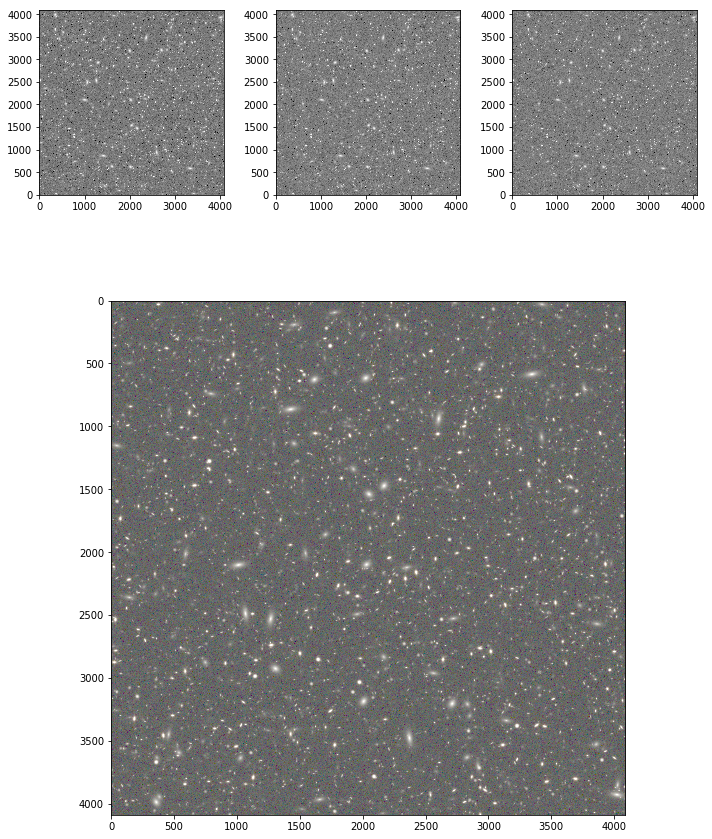

In [12]:
ex_h158 = fits.getdata('./galsim_demo_output/demo13_H158.fits')
ex_j129 = fits.getdata('./galsim_demo_output/demo13_J129.fits')
ex_y106 = fits.getdata('./galsim_demo_output/demo13_Y106.fits')
plt.figure(figsize=(10, 14))
plt.subplot(2, 3, 1)
plt.imshow(toolbox.quick_mono(ex_h158, contrast=0.01), cmap='Greys_r', origin='lower')
plt.subplot(2, 3, 2)
plt.imshow(toolbox.quick_mono(ex_j129, contrast=0.01), cmap='Greys_r', origin='lower')
plt.subplot(2, 3, 3)
plt.imshow(toolbox.quick_mono(ex_y106, contrast=0.01), cmap='Greys_r', origin='lower')
plt.subplot(2, 1, 2)
plt.imshow(toolbox.quick_rgb(ex_h158, ex_j129, ex_y106, contrast=0.01))
plt.tight_layout()